<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/ODE/Neural_Ordinary_Differential_Equations_Continuous_Depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://amirabbasasadi.github.io/deeplearning/2022/01/15/neural-ode-pytorch.html

# Introduction
Neural Ordinary Differential Equations allow you to define neural networks with continuous depth. Apart from theoretically being interesting, using such models you can define continuous time series models for forecasting or interpolation or continuous normalizing flows.


# Initial Value Problems and Numerical Solutions

As you may already know an initial value problem is defined as follows.
Given a function $f(t, y)$ and an initial value $y_0$, find a function $y$ which satisfies the differential equation:
$$
\frac{d y}{d t}=f(t, y)
$$
And further satisfying the initial condiotion $y(0)=y_0$.
The difficulty of solving such initial value problems depends on the RHS of the above equation $f(t, y)$. In most cases, there is no analytical method to solve it and it can only be solved if $f(t, y)$ has specific forms. However, there are some numerical methods for approximating the solution $y$.
Perhaps the simplest numerical approach to solve an ODE is to use the Euler method. The idea is simple. a differential equation describes changes in the value of a function. So starting with the initial value $y_0$ we can construct a solution step-by-step as in each step $t_n$ the equation tells us how to change the current value $y_n$ to compute the next value $y_{n+1}$. Using Taylor expansion we can derive the following update:
$$
y_{n+1}=y_n+m f\left(t_n, y_n\right)
$$
Where $m$ is the step size. Smaller step sizes give a more accurate approximation. As an example consider the initial value problem:
$$
\frac{d y}{d t}=-y
$$
with the initial condition $y(0)=1$. In this case the exact solution is $y=e^{-t}$. But Let's try to approximate it using the Euler method over the interval $[0,5]$ :



In [5]:
import numpy as np
def f(t,y):
  return -y

step = 0.2
steps = np.linspace(0,5,num=int(5/step))

y_app = np.zeros_like(steps)

y_app[0] = 1

for n in range(len(steps) - 1):
  y_app[n+1] = y_app[n] + step * f(steps[n], y_app[n])

In [10]:
def exact_solution(t):
  return np.exp(-t)

In [11]:
exact_solution(steps)

array([1.        , 0.81193635, 0.65924063, 0.53526143, 0.43459821,
       0.35286608, 0.2865048 , 0.23262366, 0.1888756 , 0.15335497,
       0.12451447, 0.10109782, 0.082085  , 0.06664779, 0.05411377,
       0.04393693, 0.03567399, 0.02896501, 0.02351775, 0.01909491,
       0.01550385, 0.01258814, 0.01022077, 0.00829861, 0.00673795])

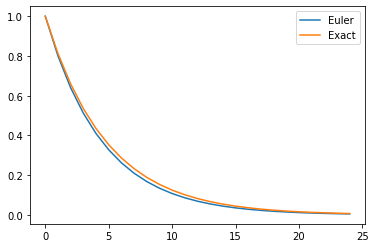

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.plot(pd.Series(y_app),label='Euler')
plt.plot(pd.Series(exact_solution(steps)),label='Exact')
plt.legend()

People use more accurate techniques to integrate ODEs like Runge-Kutta. Some methods even use adaptive step sizes. You can use scipy package to solve initial value problems. For example to solve the same problem we can use a variant of the Runge-Kutta methods:

In [15]:
from scipy.integrate import solve_ivp


solution = solve_ivp(f, (0, 5.0), y0=[1.0], method='RK45', t_eval=steps)


In [24]:
solution.y[0]

array([1.        , 0.81183381, 0.65882102, 0.53488608, 0.43461972,
       0.35312571, 0.28662893, 0.23267187, 0.18898503, 0.15353684,
       0.12463679, 0.10116554, 0.08215982, 0.0667531 , 0.05419796,
       0.0439892 , 0.03571978, 0.02902091, 0.02356756, 0.01912804,
       0.01552995, 0.01261653, 0.0102481 , 0.00832073, 0.00675601])

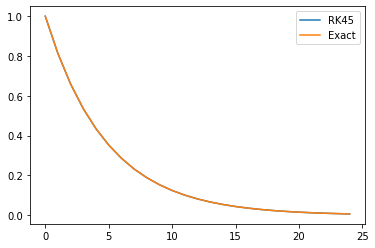

In [25]:
plt.plot(pd.Series(solution.y[0]),label='RK45')
plt.plot(pd.Series(exact_solution(steps)),label='Exact')
plt.legend()

## Neural ODE
Now consider a simple recurrent neural network. In such networks, we apply a sequence of transformations on a hidden state. For the sake of simplicity suppose in each layer we apply a simple nonlinear transformation $f$ parameterized by a vector of parameters $\theta$ which might be time-dependent so let's call it $\theta_t$ where $t$ denotes the time step. So we begin with an initial hidden state $h_0$ and update it according to the following iteration for a number of steps $T$ :
$$
h_{t+1}=h_t+f\left(h_t, \theta_t\right)
$$
Now If you look closely, This update is very similar to what we did in the Euler method to solve an initial value problem. It seems the RNN is trying to solve an initial value problem, so by making the step size smaller and smaller and increasing the number of layers in the limit to infinity we have:
$$
\frac{d \mathbf{h}(\mathbf{t})}{d t}=f(\mathbf{h}(t), t, \theta)
$$
Here $f$ is a neural network parameterized by $\theta$. Now we can define $h(T)$ as the output of this network which is called Neural Ordinary Differential Equation a parameterized differential equation.

## How to train a Neural ODE?
After defining Neural ODE the main question is How to train it? To find a proper parameter vector $\theta$ which minimizes a loss function $L$, we need to compute the gradient of the loss function. Obviously, we have to compute $h(T)$ as we have defined it as the output of the network. Since this is a differential equation we can compute $h(T)$ by solving as initial value problem using a numerical solver like the Euler method. Don't forget we have to compute the gradient of some loss functions which depends on $h(T)$. But can we differentiate through an ODE solver? Recall what we did in the Euler method once again, anything we did was differentiable so it seems differentiating through an ODE solver is straightforward and can be done using automatic differentiation systems like Autograd in PyTorch. However, a great advantages of Neural ODE is that we can perform this gradient computation much more efficiently.
## Adjoint Sensitivity Method
One of the problems associated with deep neural networks is the cost of gradient computation which increases as we add more layers to the model, Interestingly it turns out in the case of Neural ODE we can do this with constant memory using a method called Adjoint Sensitivity. Adjoint methods are a family of gradient computation methods applicable to certain problems.


As we have seen in the Euler method, the solver approximates the solution step-by-step. Let's use $z(t)$ to denote the output(state) of the solver at time step $t$. Instead of directly computing the gradient of the loss function $L$ we may define:
$$
\mathbf{a}(t)=\frac{\partial L}{\partial \mathbf{z}(t)}
$$
Here $\mathbf{a}(t)$ is called the adjoint. adjoint is obviously a function of time and as its definition suggests is the sensitivity of loss to a change in the value of state $\mathbf{z}(t)$. The dynamics of adjoint is described by a differential equation:
$$
\frac{d \mathbf{a}(t)}{d t}=-\mathbf{a}(t)^T \frac{\partial f(\mathbf{z}(t), t, \theta)}{\partial \mathbf{z}}
$$
Using both values of $\mathbf{a}(t)$ and $\mathbf{z}(t)$ the gradient of $L$ can be computed as follows using an ODE solver:
$$
\frac{d L}{d \theta}=-\int_{t_1}^{t_0} \mathbf{a}(t)^T \frac{\partial f(\mathbf{z}(t), t, \theta)}{\partial \theta} d t
$$
Where $\left[t_0, t_1\right]$ is the interval of time steps over which we approximate the ODE solution.

## Solving Initial Value Problems using torchdiffeq
The paper of Neural ODE comes with a python package called torchdiffeq to make gradient computation using the adjoint method easier. Install the package using pip:

In [26]:
%pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let’s see how to use it to solve an initial value problem. consider the same problem discussed earlier. Just like before you need to define f(t,y)
 but now we define it as a PyTorch module:

In [30]:
import torch
import torch.nn as nn

class F(nn.Module):
    def forward(self, t, y):
        return -y

In [28]:
from torchdiffeq import odeint_adjoint as odeint
# creating f(t,y)

In [31]:
func = F()

t = torch.linspace(0,5.0,25)
y0 = torch.tensor([[1.0]])

#solving the IVP

y_app = odeint(func, y0, t)

In [47]:
y_app.numpy().ravel()

array([1.        , 0.8119368 , 0.65924066, 0.5352614 , 0.4345981 ,
       0.3528661 , 0.28650483, 0.23262385, 0.18887563, 0.15335499,
       0.12451458, 0.1010979 , 0.08208501, 0.06664781, 0.05411381,
       0.04393695, 0.03567399, 0.02896501, 0.02351775, 0.01909492,
       0.01550386, 0.01258815, 0.01022077, 0.00829861, 0.00673796],
      dtype=float32)

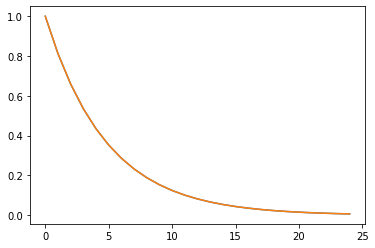

In [48]:
plt.plot(pd.Series(exact_solution(steps)),label='Exact')
plt.plot(pd.Series(y_app.numpy().ravel()),label='NeuralODE')

Although everything seems just like scipy but now we are free to define f(t,y)
 using a neural network. for example:

In [53]:
class F(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(nn.Linear(1,8),
                             nn.Tanh(),
                             nn.Linear(8,1))

  def forward(self, t, y):

      return self.net(y) * t

In [54]:
#In this case, solving the problem is the same as before:

func = F()
t = torch.linspace(0, 5.0, 5)
y0 = torch.tensor([-1.2])
y_app = odeint(func, y0, t)

In [55]:
y_app

tensor([[-1.2000],
        [-1.1845],
        [-1.1524],
        [-1.1273],
        [-1.1160]], grad_fn=<OdeintAdjointMethodBackward>)

# A Continuous Time Series Autoencoder


## Problem Definition
In this section we are going to see how to use Neural ODE to design a continuous time series autoencoder model. Such a model can be useful for time series interpolation, representation learning, or forcasting. Let’s create a synthetic time series with irregular observations. TimeSynth is a lightweight python library for generating different types of time series data. First, install it using pip:

In [56]:
! pip install git+https://github.com/TimeSynth/TimeSynth.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TimeSynth/TimeSynth.git to /tmp/pip-req-build-adn23f6h
  Running command git clone --filter=blob:none --quiet https://github.com/TimeSynth/TimeSynth.git /tmp/pip-req-build-adn23f6h
  Resolved https://github.com/TimeSynth/TimeSynth.git to commit e50cdb9015d415adf46a4eae161a087c5c378564
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for timesynth: filename=timesynth-0.2.4-py3-none-any.whl size=15445 sha256=7d174ab78cf9fa02a041d37ab286fb334b2e069d943c68875288a6c8069c561f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9hn_bs2w/wheels/d9/4a/9f/40a659e6b9971caed86881bf0de621bef68b3f5d61b4f9d3ee
  Created wheel for

In [57]:
import timesynth as ts

# Initializing a Gaussian Process signal with a Matern kernel
signal_process = ts.signals.GaussianProcess(kernel='Matern')
# Initializing Gaussian noise
white_noise = ts.noise.GaussianNoise(std=0.1)
# Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(signal_process, noise_generator=white_noise)

In [58]:
# time steps to sample the time series
samples = np.sort(np.random.uniform(0,5,60))
# sampling the time series
# sampling the time series
series, signal, noise = timeseries.sample(samples)

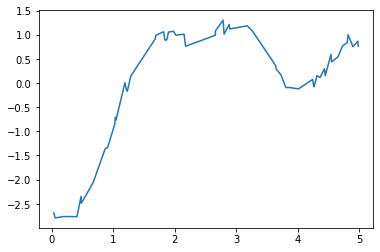

In [59]:
plt.plot(samples, series)

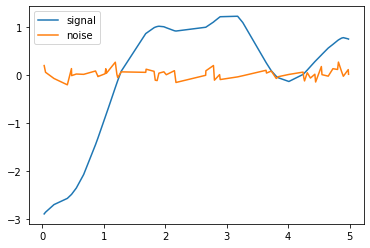

In [60]:
plt.plot(samples, signal, label='signal')
plt.plot(samples, noise, label='noise')
plt.legend()

So far we have a time series with irregular observations. Using a continuous time autoencoder we can interpolate arbitrary time points and use them for forecasting. There are many other applications for a continuous autoencoder like denoising, forecasting, …

## Model Specification
The overall architecture of the autoencoder has been shown in the figure below:
An encoder network will encode the series to produce a latent vector z0
. This latent vector can be used as the initial condition of the Neural ODE. By solving the Neural ODE we can obtain the latent representation of each time steps zt0,zt1,…,ztn
. You may ask why the ODE should generate the latent points? The reason is in this case we will be able to sample the encoded series in arbitrary time points.


Neural ODE is responsible to model the dynamics of the latent space. Encoders usually describe the latent space itself. But in this model we first describe the dynamics of latent space and then generate the latent space by solving the Neural ODE. The Neural ODE is as follows:

In [61]:
class Encoder_ODE(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.latent_dim = latent_dim
    self.net = nn.Sequential(nn.Linear(self.latent_dim+1, self.latent_dim),
                             nn.CELU(),
                             nn.Linear(self.latent_dim, self.latent_dim))
   
    self.omega = nn.Parameter(torch.rand((1,)))
    
  def forward(self, t, y):
    # handling seasonality
    time = torch.sin(self.omega*t.view(1, 1))
    combined = torch.cat([time, y], dim=1)
    return self.net(combined)

For decoding the latent values we can define a simple MLP which acts on each latent time point zi
 separately. This way it is easier to generate the series in arbitrary points after training the Autoencoder.

In [62]:
class AE(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.latent_dim = latent_dim
    self.ode = Encoder_ODE(self.latent_dim)
    self.lstm_encoder = nn.LSTM(1, self.latent_dim, batch_first=True)
    self.fc_decoder = nn.Sequential(nn.Linear(self.latent_dim, self.latent_dim),
                                    nn.Tanh(),
                                    nn.Linear(self.latent_dim, 1))
  
  def forward(self, t, y):
    # zero initialized hidden vector
    (h0, c0) = (torch.zeros(1, 1, self.latent_dim),
                torch.zeros(1, 1, self.latent_dim))
    # encoding the time series
    _, (h, c) = self.lstm_encoder(y.view(1, -1, 1), (h0, c0))

    # using the last hidden value as the initial condition for solving ODE 
    z0 = h[0]
    # generating the latent points by solving ODE
    z = odeint(self.ode, z0, t_train).squeeze()
    y_decoded = self.fc_decoder(z)
    return y_decoded

In [63]:
t_train = torch.from_numpy(samples).float()
y_train = torch.from_numpy(series).float()

In [64]:
import torch.optim as optim
model = AE(latent_dim=3)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.MSELoss()

In [65]:
loss_track = []
epochs = 300
for epoch in range(epochs):

    optimizer.zero_grad()
    y_decoded = model(t_train,y_train)
    train_loss = criterion(y_decoded.squeeze(), y_train)

    train_loss.backward()

    optimizer.step()

    loss_track.append(train_loss.item())

<AxesSubplot:>

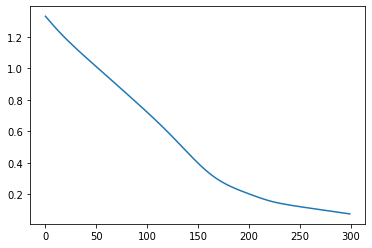

In [68]:
pd.Series(loss_track).plot()

<AxesSubplot:>

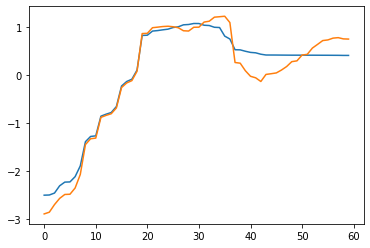

In [82]:
pd.Series(y_decoded.detach().numpy().ravel()).plot()
pd.Series(signal).plot()